©Claudio Sartori - Classification

# Classification with hyperparameter tuning

### Aim: Show classification with different strategies for the tuning and evaluation of the classifier
1. simple __holdout__
1. __cross validation__ on training set, then score on test set

__NB__: You should not interpret those experiments as a way to find the _best_ evaluation method, but simply as examples of _how_ to do the evaluation. 

If you look at the final report, both methods are meant for increasing evaluation reliability, method __2__ is the more reliable, but it requires several repetitions for cross validation, therefore, if the learning method is expensive, it requires long processing time. If, due to intrinsic variation caused by random sampling, it turns out that method __1__ gives higher accuracy, this means simply that the forecast towards generalisation is less reliable.    

### Workflow
- download the data
- drop the useless data
- separe the predicting attributes X from the class attribute y
- split X and y into training and test

- part 1 - single run with default parameters
    - initialise an estimator with the chosen model generator
    - fit the estimator with the training part of X
    - show the tree structure
    - part 1.1 
        - predict the y values with the fitted estimator and the train data
            - compare the predicted values with the true ones and compute the accuracy on the training set 
    - part 1.2
        - predict the y values with the fitted estimator and the test data
            - compare the predicted values with the true ones and compute the accuracy on the test set 

- part 2 - compute accuracy with cross validation
    - prepare the structure to hold the accuracy data for the multiple runs
    - repeat for all the values of the parameter
        - initialise an estimator with the current parameter value
        - compute the accuracy with cross validation and store the value
    - find the parameter value for the top accuracy
    - fit the estimator with the entire X
    - show the resulting tree and classification report

The data are already in your folder, use the name `winequality-red.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
random_state = 15
np.random.seed(random_state)
# the random state is reset here in numpy, all the scikit-learn procedure use the numpy random state
# obviously the experiment can be repeated exactly only with a complete run of the program

data_url = "winequality-red.csv"
target_name = 'quality'

Read the data into a dataframe and show the size

In [2]:
df=pd.read_csv(data_url, sep=';')
print(df.shape)

(1599, 12)


Have a quick look to the data.
- use the .shape attribute to see the size
- use the `.head()` function to see column names and some data
- use the `.hist()` method for an histogram of the columns
- use the .unique method to see the class values

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

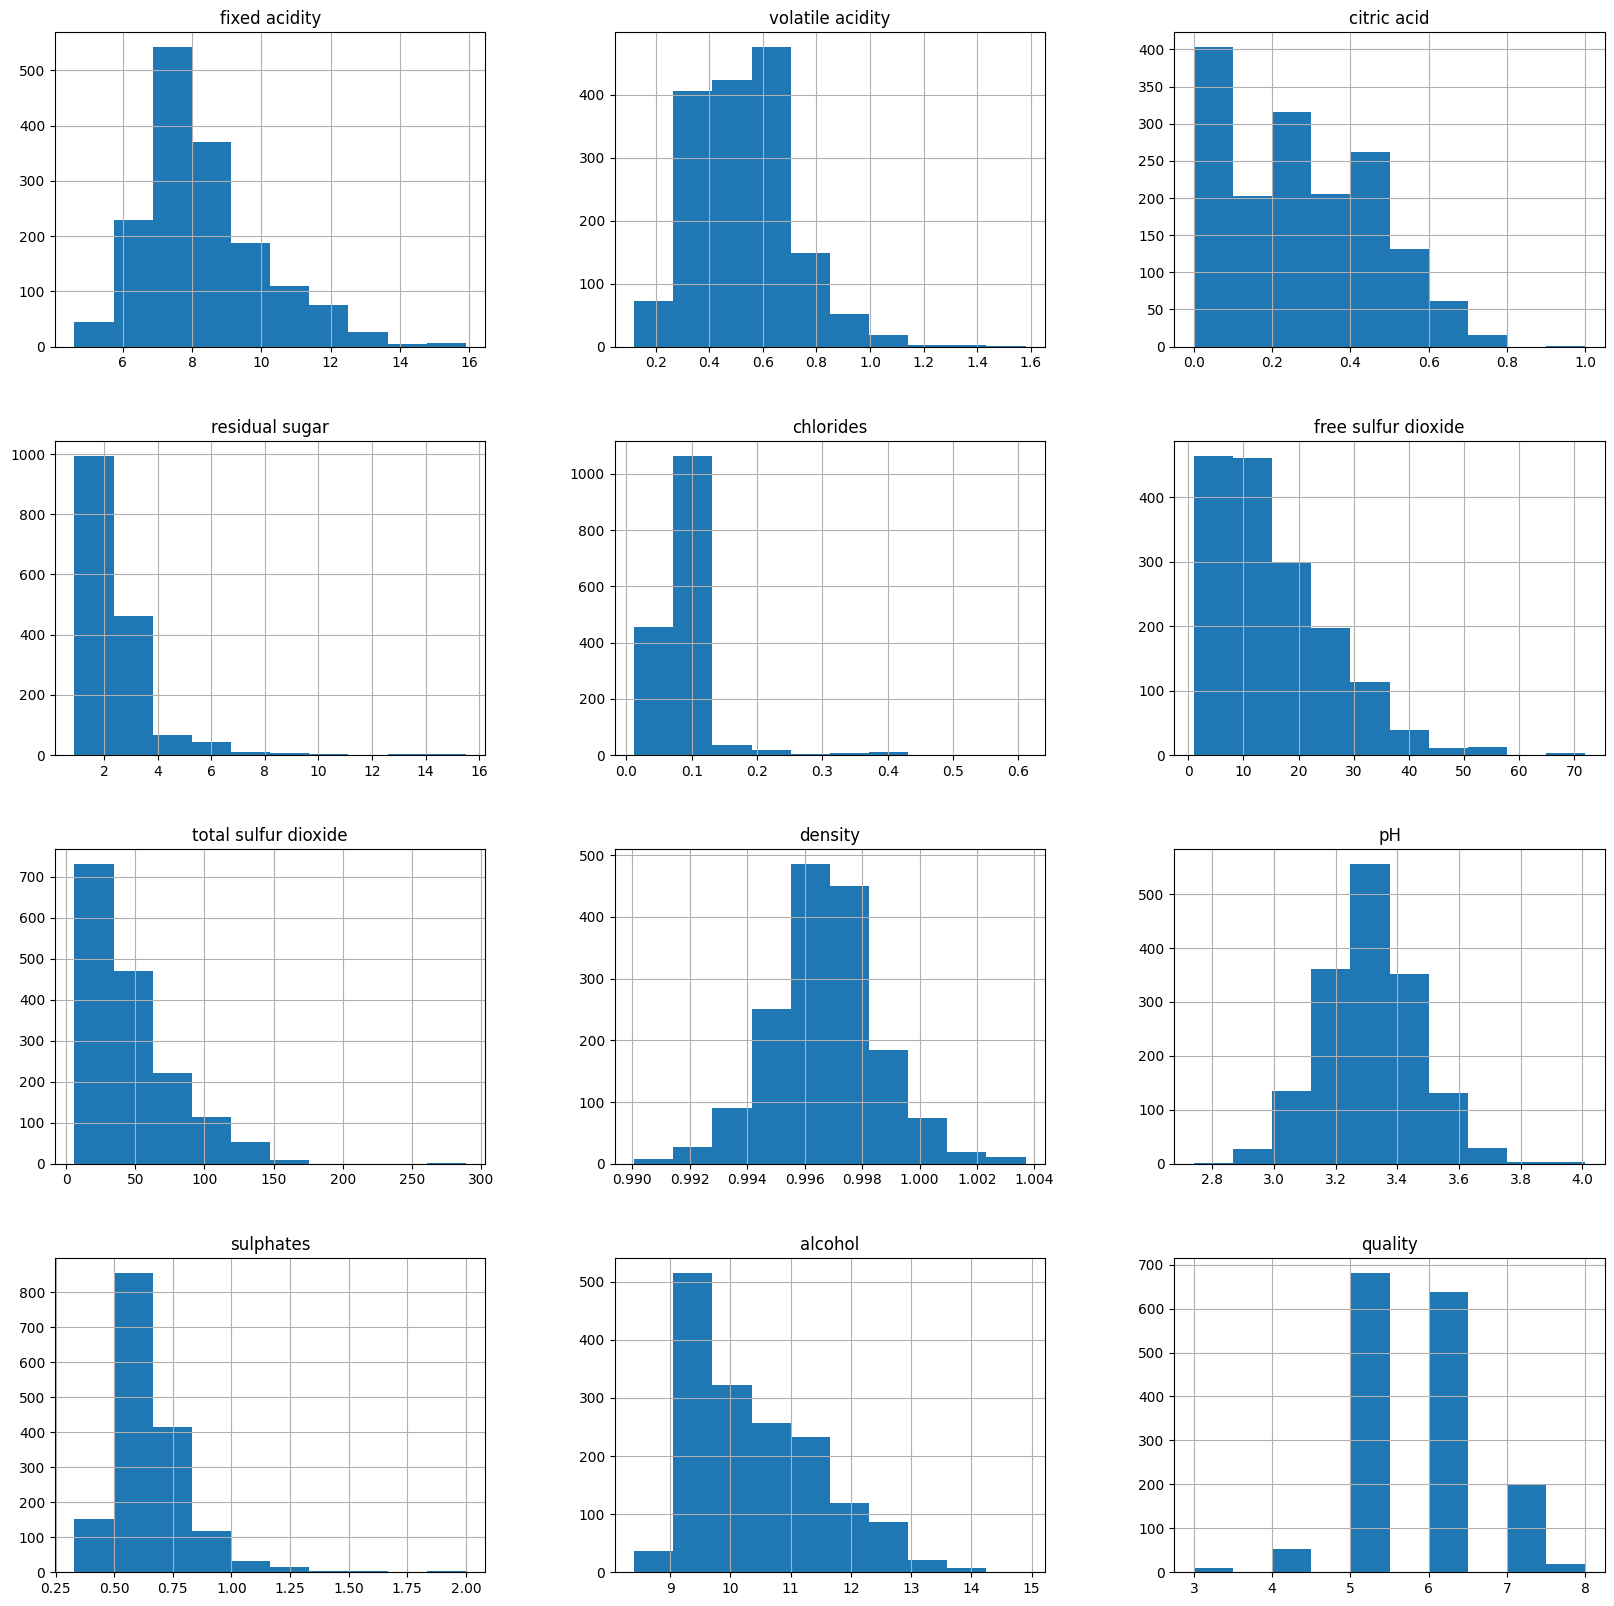

In [4]:
print(df.head())
print(df.hist())


Use `seaborn.pairplot` to show the the pairplots of the attributes, using the target as `hue`

NB: a semicolon at the end of a statement suppresses the `Out[]`

In [5]:
#sns.pairplot(df, hue=target_name)

Print the unique class labels (hint: use the `unique` method of pandas Series)

In [6]:
print(df[target_name].unique())

[5 6 7 4 8 3]


#### Split the data into the predicting values X and the class y
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [7]:
target_column=df[target_name]
df=df.drop(target_name, axis=1)

Another quick look to data

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


## Prepare a simple model selection: holdout method
- Split X and y in train and test
- Show the number of samples in train and test, show the number of features

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, target_column, test_size=0.34, random_state=1)
print("There are "+ str(X_train.shape[0]) + " samples in the training dataset")
print("There are "+ str(X_test.shape[0]) + " samples in the testing dataset")
print("Each sample has "+ str(X_train.shape[1]) + " features")

There are 1055 samples in the training dataset
There are 544 samples in the testing dataset
Each sample has 11 features


## Part 1

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(criterion="entropy")`
- Fit the estimator on the train data and target

In [10]:
dt=tree.DecisionTreeClassifier(criterion="entropy", max_depth=None)
dt.fit(X_train, y_train)
print(X_train.shape)

(1055, 11)


### Part 1.1

Let's see how it works on training data
- predict the target using the fitted estimator on the training data
- compute the accuracy on the training set using `accuracy_score(<target>,<predicted_target) * 100`

In [11]:
#predict the target using fitted estimator on training data
y_train_pred = dt.predict(X_train)
print("train accuracy: "+str(accuracy_score(y_train, y_train_pred)*100))




train accuracy: 100.0


### Part 1.2

Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [19]:
y_test_pred = dt.predict(X_test)
accuracy_ho=accuracy_score(y_test, y_test_pred)*100
print("test accuracy: "+str(accuracy_ho))
fitted_max_depth = dt.tree_.max_depth
parameter_values = range(1,fitted_max_depth+1)
print("The fitted tree has a maximum depth of "+str(fitted_max_depth))


test accuracy: 59.375
The fitted tree has a maximum depth of 18


## Part 2 - Tuning with __Cross Validation__
Optimisation of the hyperparameter with __cross validation__.
Now we will tune the hyperparameter looping on cross validation with the __training set__, then we will fit the estimator on the training set and evaluate the performance on the __test set__

- initialize an empty list for the scores
- loop varying `par` in `parameter_values`
    - initialize an estimator with a DecisionTreeClassifier, using `par` as maximum depth and `entropy` as criterion
    - compute the score using the estimator on the `train` part of the features and the target using 
        - `cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv = 5)`
        - the result is list of scores
    - compute the average of the scores and append it to the end of the list
- print the scores

In [20]:
scores=[]
for par in parameter_values:
    dt=tree.DecisionTreeClassifier(criterion="entropy", max_depth=par)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict(X_train)
    scores.append(cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy').mean())
print(scores)

[0.5289099526066351, 0.5289099526066351, 0.5582938388625593, 0.5639810426540285, 0.5687203791469194, 0.557345971563981, 0.5677725118483412, 0.5687203791469194, 0.5753554502369668, 0.5734597156398105, 0.581042654028436, 0.5753554502369669, 0.5734597156398105, 0.5895734597156398, 0.5734597156398105, 0.576303317535545, 0.5781990521327014, 0.5781990521327014]


Plot using the `parameter_values` and the list of `scores`

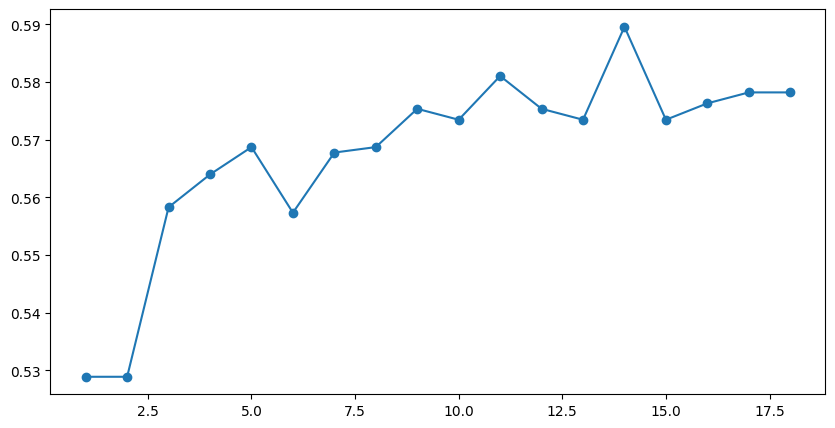

In [21]:
plt.figure(figsize=(10,5))
plt.plot(parameter_values, scores, "o-")

### Fit the tree after cross validation and print summary
- store the parameter value giving the best score with `np.argmax(scores)`
- initialize an estimator as a DecisionTreeClassifier, using the best parameter value computed above as maximum depth and `entropy` as criterion
- fit the estimator using the `train` part
- use the fitted estimator to predict using the test features
- compute the accuracy on the test and store it on a variable for the final summary
- print the accuracy on the test set and the best parameter value

In [32]:
best_parameter = parameter_values[np.argmax(scores)]
estimator=tree.DecisionTreeClassifier(criterion="entropy", max_depth=best_parameter)
estimator.fit(X_train, y_train)
y_test_pred = estimator.predict(X_test)
accuracy_cv=accuracy_score(y_test, y_test_pred)*100
print("test accuracy: "+str(accuracy_cv))
print("best parameter: "+str(best_parameter))

test accuracy: 58.08823529411765
best parameter: 14


Show a more detailed information using the `classification_report` function of `sklearn.metrics`, using the true and predicted target values

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        21
           5       0.68      0.67      0.67       227
           6       0.58      0.59      0.58       221
           7       0.46      0.49      0.47        68
           8       0.25      0.20      0.22         5

    accuracy                           0.58       544
   macro avg       0.33      0.32      0.33       544
weighted avg       0.58      0.58      0.58       544



- **micro**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.
- **macro**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- **weighted**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

Print the `confusion_matrix`, using the function of `sklearn.metrics`

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_test_pred)

array([[  0,   1,   1,   0,   0,   0],
       [  1,   0,  11,   8,   1,   0],
       [  2,  10, 152,  58,   5,   0],
       [  2,   3,  54, 130,  29,   3],
       [  0,   1,   6,  28,  33,   0],
       [  0,   0,   1,   0,   3,   1]])

### Final report
Print a summary of the four experiments

In [35]:
print("                                        Accuracy   Hyperparameter")
print("Simple HoldOut and full tree        :   {:.1f}%      {}"\
      .format(accuracy_ho, fitted_max_depth))
print("CrossValidation and tuning          :   {:.1f}%      {}"\
      .format(accuracy_cv, best_parameter))

                                        Accuracy   Hyperparameter
Simple HoldOut and full tree        :   59.4%      18
CrossValidation and tuning          :   58.1%      14


In [36]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


### Suggested exercises
- try to optimise the parameters "min_impurity_decrease"
- try to optimise using 'gini' instead of 'entropy'
- try to transform the classes: quality<7 transformed to `low`, quality>=7 transformed to `high`, then train and optimize with cross-validation, then test
    - try to fit using the parameter class `class_weight` to balance the classes
    - optimize the [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) with `macro` weighting